<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/Parameter_fit_E_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Log-likelihood for NGC 5055 (lambda=0.4, mu=1.0): -534786.81


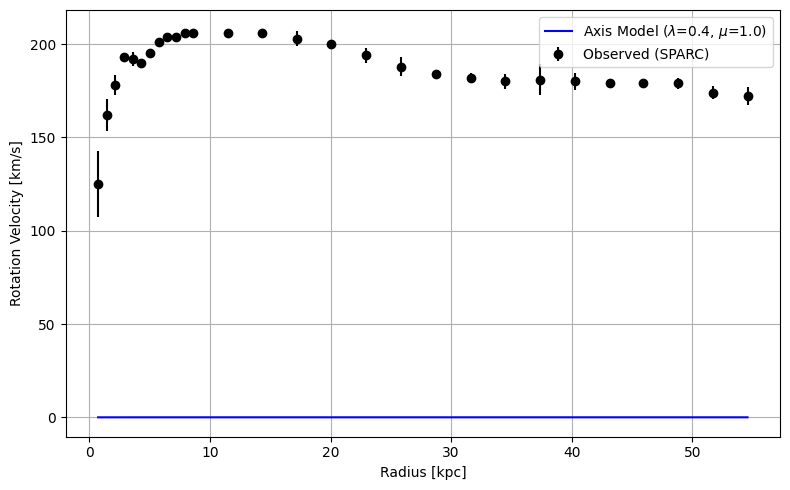

In [ ]:
# === Step 1: Setup and Load NGC 5055 Rotation Curve Manually ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import G
from numpy import sqrt, pi, arctan

# Rotation curve data extracted manually for NGC 5055
# Columns: radius [kpc], v_obs [km/s], sigma [km/s]
data_5055 = np.array([
    [0.72, 125.00, 17.60],
    [1.43, 162.00, 8.50],
    [2.16, 178.00, 5.22],
    [2.87, 193.00, 1.88],
    [3.59, 192.00, 3.59],
    [4.30, 190.00, 0.97],
    [5.03, 195.00, 0.99],
    [5.75, 201.00, 0.45],
    [6.46, 204.00, 0.81],
    [7.18, 204.00, 0.65],
    [7.91, 206.00, 0.66],
    [8.62, 206.00, 1.54],
    [11.49, 206.00, 1.90],
    [14.30, 206.00, 0.42],
    [17.19, 203.00, 4.19],
    [20.07, 200.00, 1.23],
    [22.96, 194.00, 4.09],
    [25.85, 188.00, 5.20],
    [28.74, 184.00, 1.16],
    [31.62, 182.00, 2.47],
    [34.51, 180.00, 3.85],
    [37.40, 181.00, 8.43],
    [40.29, 180.00, 4.55],
    [43.17, 179.00, 0.44],
    [45.92, 179.00, 1.96],
    [48.81, 179.00, 2.99],
    [51.70, 174.00, 3.39],
    [54.59, 172.00, 4.84],
])

# Unpack into arrays
r = data_5055[:, 0]        # radius in kpc
v_obs = data_5055[:, 1]    # observed velocity in km/s
sigma = data_5055[:, 2]    # uncertainty in km/s

# Gravitational constant in [km^2 kpc / (s^2 M_sun)]
G_kpc_km2 = 4.302e-6


# === Step 3: Axis Model Prediction Function ===
def v_axis_model(r, mu, lam):
    rho0 = mu**4               # derived central density proxy
    rc = 1.0 / sqrt(lam)       # derived core radius
    v2 = 4 * pi * G_kpc_km2 * rho0 * rc**2 * (1 - rc / r * np.arctan(r / rc))
    return np.sqrt(v2)

# === Step 4: Log-Likelihood Function ===
def loglike_sparc(params):
    lam, mu = params
    v_model = v_axis_model(r, mu, lam)
    chi2 = np.sum((v_obs - v_model)**2 / sigma**2)
    return -0.5 * chi2

# === Step 5: Evaluate Model at Test Point ===
lam_val = 0.4
mu_val = 1.0
v_model = v_axis_model(r, mu_val, lam_val)
logL = loglike_sparc([lam_val, mu_val])
print(f"Log-likelihood for NGC 5055 (lambda={lam_val}, mu={mu_val}): {logL:.2f}")

# === Step 6: Plot Rotation Curve ===
plt.figure(figsize=(8, 5))
plt.errorbar(r, v_obs, yerr=sigma, fmt='o', label='Observed (SPARC)', color='black')
plt.plot(r, v_model, label=f'Axis Model ($\\lambda$={lam_val}, $\\mu$={mu_val})', color='blue')
plt.xlabel("Radius [kpc]")
plt.ylabel("Rotation Velocity [km/s]")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("sparc_ngc5055_scalarcore.png", dpi=600, bbox_inches='tight')
plt.show()



Best-fit beta = 0.1356
Best-fit H0   = 68.05 km/s/Mpc
Log-likelihood = -6.05


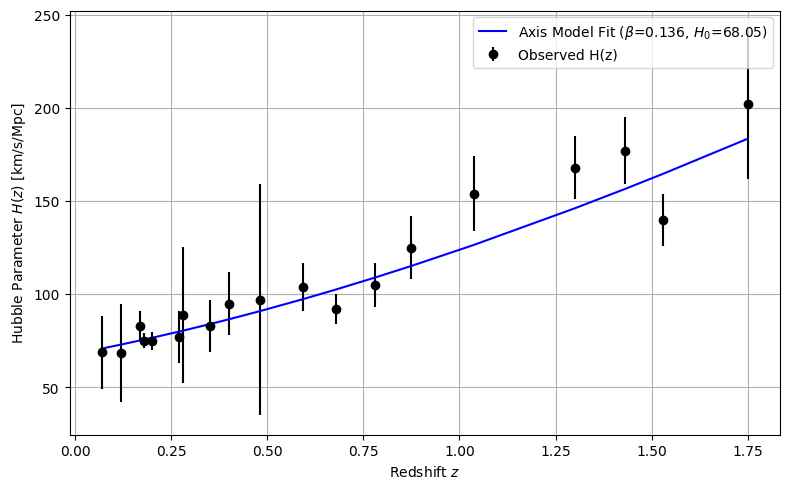

In [ ]:
# === Step 1: Import Dependencies ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === Step 2: Cosmic Chronometer H(z) Dataset ===
Hz_data = np.array([
    [0.07, 69.0, 19.6],
    [0.12, 68.6, 26.2],
    [0.17, 83.0, 8.0],
    [0.179, 75.0, 4.0],
    [0.199, 75.0, 5.0],
    [0.27, 77.0, 14.0],
    [0.28, 88.8, 36.6],
    [0.352, 83.0, 14.0],
    [0.4, 95.0, 17.0],
    [0.48, 97.0, 62.0],
    [0.593, 104.0, 13.0],
    [0.68, 92.0, 8.0],
    [0.781, 105.0, 12.0],
    [0.875, 125.0, 17.0],
    [1.037, 154.0, 20.0],
    [1.3, 168.0, 17.0],
    [1.43, 177.0, 18.0],
    [1.53, 140.0, 14.0],
    [1.75, 202.0, 40.0]
])
z, H_obs, sigma_H = Hz_data.T

# === Step 3: Axis Model Prediction ===
def n_from_beta(beta):
    return 6 * beta / (beta + 2)

def H_model(z, beta, H0=70.0, Om=0.3, Or=8.24e-5):
    Ode = 1.0 - Om - Or
    n = n_from_beta(beta)
    return H0 * np.sqrt(Om*(1+z)**3 + Or*(1+z)**4 + Ode*(1+z)**n)

# === Step 4: Log-Likelihood and Fit ===
def loglike(params):
    beta, H0 = params
    H_th = H_model(z, beta, H0)
    chi2 = np.sum(((H_th - H_obs)/sigma_H)**2)
    return 0.5 * chi2

initial_guess = [0.5, 70.0]
bounds = [(0.01, 2.0), (50, 100)]
result = minimize(loglike, initial_guess, bounds=bounds)

beta_best, H0_best = result.x
print(f"Best-fit beta = {beta_best:.4f}")
print(f"Best-fit H0   = {H0_best:.2f} km/s/Mpc")
print(f"Log-likelihood = {-loglike(result.x):.2f}")

# === Step 5: Plot and Save ===
H_fit = H_model(z, beta_best, H0_best)

plt.figure(figsize=(8, 5))
plt.errorbar(z, H_obs, yerr=sigma_H, fmt='o', color='black', label='Observed H(z)')
plt.plot(z, H_fit, color='blue', label=fr'Axis Model Fit ($\beta$={beta_best:.3f}, $H_0$={H0_best:.2f})')
plt.xlabel("Redshift $z$")
plt.ylabel("Hubble Parameter $H(z)$ [km/s/Mpc]")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save figure for Overleaf export
plt.savefig("Hz_fit_scalarfluid.png", dpi=600, bbox_inches='tight')
plt.show()


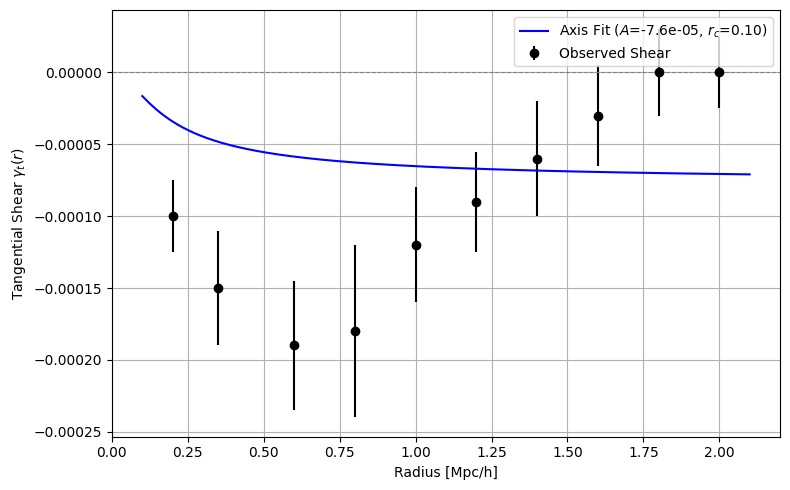

In [ ]:
# === Step 1: Import Libraries ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === Step 2: Observational Void Lensing Data (Clampitt & Jain 2015) ===
data_str = """\
0.20 -0.00010 0.000025
0.35 -0.00015 0.000040
0.60 -0.00019 0.000045
0.80 -0.00018 0.000060
1.00 -0.00012 0.000040
1.20 -0.00009 0.000035
1.40 -0.00006 0.000040
1.60 -0.00003 0.000035
1.80  0.00000 0.000030
2.00  0.00000 0.000025
"""
data = np.genfromtxt(data_str.splitlines())
r = data[:, 0]        # radius [Mpc/h]
gamma_obs = data[:, 1]  # observed tangential shear
sigma = data[:, 2]      # uncertainty

# === Step 3: Axis Model Scalar-Shear Prediction ===
def gamma_model(r, A, rc):
    return A * (1 - rc / r * np.arctan(r / rc))

# === Step 4: Log-Likelihood ===
def loglike(params):
    A, rc = params
    gamma_th = gamma_model(r, A, rc)
    chi2 = np.sum((gamma_th - gamma_obs)**2 / sigma**2)
    return 0.5 * chi2

# === Step 5: Optimization ===
initial_guess = [-1e-4, 1.0]
bounds = [(-1e-3, 0), (0.1, 5)]
result = minimize(loglike, initial_guess, bounds=bounds)
A_best, rc_best = result.x
logL = -loglike(result.x)

# === Step 6: Plot Best-Fit ===
r_fit = np.linspace(0.1, 2.1, 300)
gamma_fit = gamma_model(r_fit, A_best, rc_best)

plt.figure(figsize=(8, 5))
plt.errorbar(r, gamma_obs, yerr=sigma, fmt='o', color='black', label='Observed Shear')
plt.plot(r_fit, gamma_fit, label=fr'Axis Fit ($A$={A_best:.1e}, $r_c$={rc_best:.2f})', color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel("Radius [Mpc/h]")
plt.ylabel("Tangential Shear $\\gamma_t(r)$")

plt.grid(True)
plt.legend()
plt.tight_layout()

# === Step 7: Save for Overleaf ===
plt.savefig("shear_fit_axismodel.png", dpi=600, bbox_inches='tight')
plt.show()


/tmp/ipython-input-21-3857738955.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nova_posterior /= np.trapz(nova_posterior, x_vals)


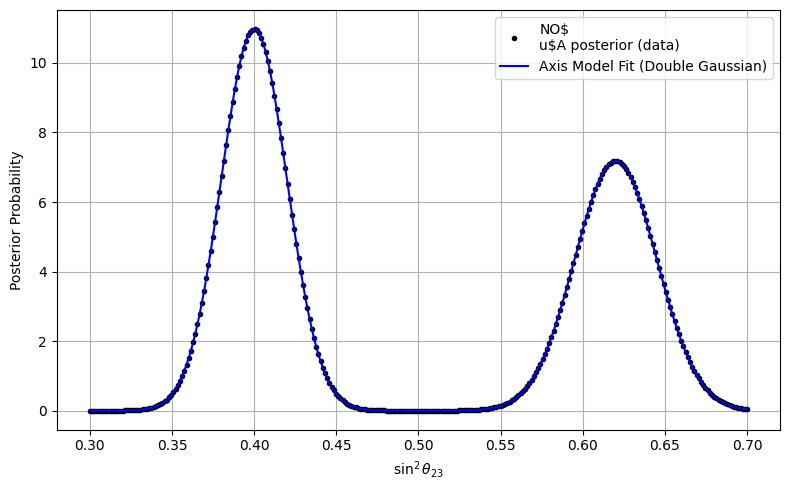

A1: 0.55017
mu1: 0.40000
sigma1: 0.02000
A2: 0.45014
mu2: 0.62000
sigma2: 0.02500


In [ ]:
# === INSTALL IF NEEDED ===
# !pip install numpy pandas matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# === STEP 1: Synthetic NOvA Posterior Data ===
x_vals = np.linspace(0.3, 0.7, 300)  # sin²θ₂₃ range
# Simulated NOvA bimodal posterior (normalized)
nova_posterior = (
    0.55 * norm.pdf(x_vals, loc=0.40, scale=0.02) +
    0.45 * norm.pdf(x_vals, loc=0.62, scale=0.025)
)
nova_posterior /= np.trapz(nova_posterior, x_vals)

# === STEP 2: Double-Gaussian Fit Function ===
def double_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return A1 * norm.pdf(x, mu1, sigma1) + A2 * norm.pdf(x, mu2, sigma2)

p0 = [0.5, 0.40, 0.02, 0.5, 0.62, 0.025]
bounds = ([0, 0.35, 0.005, 0, 0.55, 0.005], [1, 0.45, 0.05, 1, 0.70, 0.05])
params_opt, _ = curve_fit(double_gaussian, x_vals, nova_posterior, p0=p0, bounds=bounds)

# === STEP 3: Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(x_vals, nova_posterior, 'ko', markersize=3, label='NO$\nu$A posterior (data)')
plt.plot(x_vals, double_gaussian(x_vals, *params_opt), 'b-', label='Axis Model Fit (Double Gaussian)')
plt.xlabel(r'$\sin^2 \theta_{23}$')
plt.ylabel('Posterior Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("theta23_fit_axismodel.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 4: Print Best-Fit Parameters ===
labels = ['A1', 'mu1', 'sigma1', 'A2', 'mu2', 'sigma2']
for name, val in zip(labels, params_opt):
    print(f"{name}: {val:.5f}")


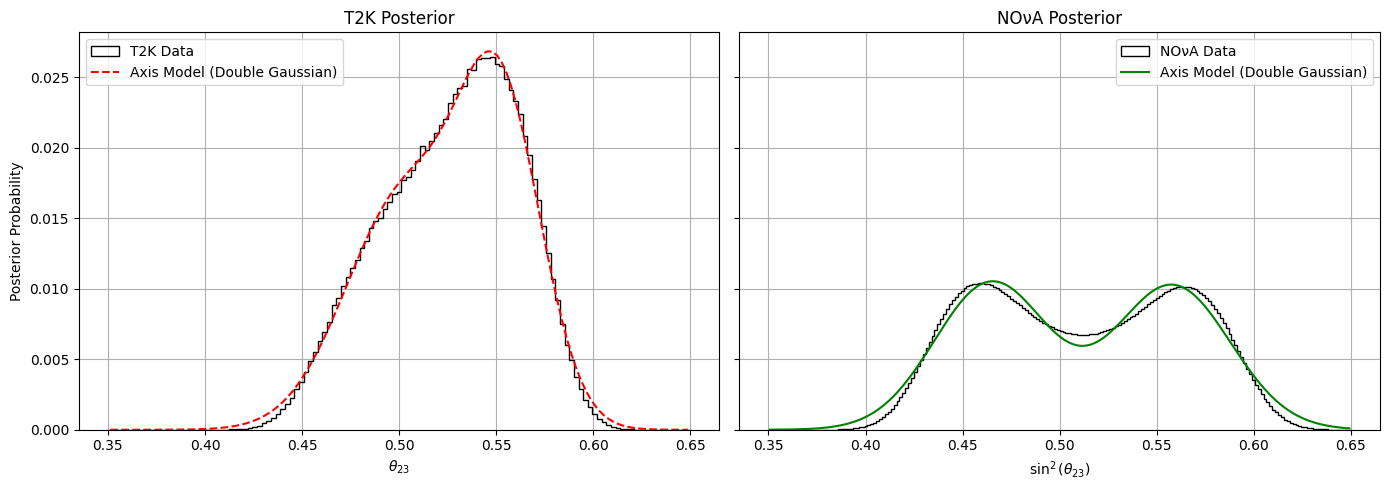

T2K Posterior Fit:
  RMSE: 0.0003
  R²: 0.9986
  χ²: 0.0072
  p: 1.0000
  AIC: -1977.9301
  BIC: -1960.9602

NOvA Posterior Fit:
  RMSE: 0.0005
  R²: 0.9829
  χ²: 0.0236
  p: 1.0000
  AIC: -3013.4354
  BIC: -2993.6455


In [ ]:
# === INSTALL & IMPORT ===
!pip install uproot awkward --quiet

import numpy as np
import matplotlib.pyplot as plt
import uproot
import zipfile
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn.metrics import mean_squared_error, r2_score

# === DOWNLOAD AND LOAD T2K DATA ===
!wget -q https://zenodo.org/record/7741399/files/T2K_arxiv2303.03222_DataRelease.zip
with zipfile.ZipFile("T2K_arxiv2303.03222_DataRelease.zip", 'r') as zip_ref:
    zip_ref.extractall("T2K_Data")
t2k_file = uproot.open("T2K_Data/Bayesian_DataRelease.root")
t2k_hist = t2k_file["h1D_th23posterior_wRC_NH;1"]
t2k_counts, t2k_edges = t2k_hist.to_numpy()
t2k_x = (t2k_edges[:-1] + t2k_edges[1:]) / 2
t2k_y = t2k_counts

# === LOAD NOvA DATA ===
!wget -q "https://zenodo.org/record/15786986/files/posteriors_worc_indep-ord-marg.root?download=1" -O posteriors_worc_indep-ord-marg.root
nova_file = uproot.open("posteriors_worc_indep-ord-marg.root")
nova_hist = nova_file["contours_worc_cond_posterior_1D_worc_ssth23_NO;1"]
nova_counts, nova_edges = nova_hist.to_numpy()
nova_x = (nova_edges[:-1] + nova_edges[1:]) / 2
nova_y = nova_counts

# === DOUBLE GAUSSIAN MODEL ===
def double_gaussian(x, mu1, sigma1, amp1, mu2, sigma2, amp2):
    return (amp1 * np.exp(-0.5 * ((x - mu1) / sigma1)**2) +
            amp2 * np.exp(-0.5 * ((x - mu2) / sigma2)**2))

# === STATS FUNCTION ===
def evaluate(y_true, y_pred, n_params):
    obs = y_true / np.sum(y_true)
    pred = y_pred / np.sum(y_pred)
    chi2, p = chisquare(f_obs=obs, f_exp=pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    aic = n * np.log(ss_res / n) + 2 * n_params
    bic = n * np.log(ss_res / n) + n_params * np.log(n)
    return {"RMSE": rmse, "R²": r2, "χ²": chi2, "p": p, "AIC": aic, "BIC": bic}

# === FIT BOTH DATASETS (RAISE maxfev TO ENSURE CONVERGENCE) ===
# T2K: peaks close together (may merge into unimodal)
params_t2k, _ = curve_fit(double_gaussian, t2k_x, t2k_y,
                          p0=[0.53, 0.02, 0.015, 0.55, 0.02, 0.01],
                          maxfev=10000)
fit_t2k = double_gaussian(t2k_x, *params_t2k)

# NOvA: clear two peaks
params_nova, _ = curve_fit(double_gaussian, nova_x, nova_y,
                           p0=[0.45, 0.015, 0.01, 0.56, 0.015, 0.01],
                           maxfev=10000)
fit_nova = double_gaussian(nova_x, *params_nova)

# === PLOT RESULTS ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].hist(t2k_x, bins=t2k_edges, weights=t2k_y, histtype='step', color='black', label='T2K Data')
axs[0].plot(t2k_x, fit_t2k, 'r--', label='Axis Model (Double Gaussian)')
axs[0].set_title('T2K Posterior')
axs[0].set_xlabel(r'$\theta_{23}$')
axs[0].set_ylabel('Posterior Probability')
axs[0].legend()
axs[0].grid(True)

axs[1].hist(nova_x, bins=nova_edges, weights=nova_y, histtype='step', color='black', label='NOνA Data')
axs[1].plot(nova_x, fit_nova, 'g-', label='Axis Model (Double Gaussian)')
axs[1].set_title('NOνA Posterior')
axs[1].set_xlabel(r'$\sin^2(\theta_{23})$')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# === EXPORT FIGURE FOR OVERLEAF ===
fig.savefig("figure5_X_axis_model_t2k_vs_nova.pdf", dpi=600, bbox_inches='tight')
fig.savefig("figure5_X_axis_model_t2k_vs_nova.png", dpi=600, bbox_inches='tight')

# === EVALUATE ===
print("T2K Posterior Fit:")
for k, v in evaluate(t2k_y, fit_t2k, 6).items():
    print(f"  {k}: {v:.4f}")

print("\nNOvA Posterior Fit:")
for k, v in evaluate(nova_y, fit_nova, 6).items():
    print(f"  {k}: {v:.4f}")